In [33]:
import pandas as pd
import numpy as np
import importlib
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support as score
from xgboost import XGBClassifier
import shap

In [ ]:
import os
os.chdir('..')

In [ ]:
from config import mfp
from src.plot_utils import clean_plot
from src.filter import Filter

In [5]:
gtrain = pd.read_csv(mfp("data/garlic_scoring.csv"), encoding='latin1')[['PMID', 'abstract', 'paper', 'mesh_terms', 'qual_terms', 'is_useful']]
gtrain['food'] = 'garlic'
ctrain = pd.read_csv(mfp("data/cocoa_scoring.csv"), encoding='latin1')[['PMID', 'abstract', 'paper', 'mesh_terms', 'qual_terms', 'is_useful']]
ctrain['food'] = 'cocoa'

In [6]:
gtrain = gtrain[gtrain['is_useful'].notnull()]
ctrain = ctrain[ctrain['is_useful'].notnull()]

gtrain['is_useful'] = gtrain['is_useful'].replace(2, 1, regex=True)
ctrain['is_useful'] = ctrain['is_useful'].replace(2, 1, regex=True)

In [10]:
gmodel_data = Filter()
cmodel_data = Filter()

gmodel_data.build_features(input_data = gtrain, is_traindata = True)
cmodel_data.build_features(input_data = ctrain, is_traindata = True)

Creating features...


299it [06:03,  1.22s/it]


Creating features...


324it [05:52,  1.09s/it]


In [29]:
# gdata = gmodel_data.data.copy()
# cdata = cmodel_data.data.copy()

# gdata.to_pickle(mfp('misc_save/garlic_train_data.pkl'))
# cdata.to_pickle(mfp('misc_save/cocoa_train_data.pkl'))

gdata = pd.read_pickle(mfp('misc_save/garlic_train_data.pkl'))
cdata = pd.read_pickle(mfp('misc_save/cocoa_train_data.pkl'))

gtrain, gtest, gval = balanced_sample(gdata)
ctrain, ctest, cval = balanced_sample(cdata)

train = pd.concat([gtrain, ctrain], axis=0, ignore_index=True, sort=False)
test = pd.concat([gtest, ctest], axis=0, ignore_index=True, sort=False)
val = pd.concat([gval, cval], axis=0, ignore_index=True, sort=False) # Does not incorporate SMOTE

In [74]:
# Sample equal proportions of imbalanced classes
def balanced_sample(df, train_frac=.7, val_frac=.2):
    val_s1 = df[df['class'] == 0].sample(frac=val_frac)
    val_s2 = df[df['class'] == 1].sample(frac=val_frac)
    
    val= pd.concat([val_s1, val_s2], axis=0, ignore_index=True, sort=False)
    
    df = df.drop(val_s1.index.tolist() + val_s2.index.tolist(), axis = 0)
    
    y = df.copy()['class']
    x = df.copy().drop('class', axis = 1)
    
    smote_x, smote_y = SMOTE().fit_sample(x, y)

    df = pd.DataFrame(smote_x, columns = x.columns)
    df['class'] = pd.Series(smote_y)
    
    train_s1 = df[df['class'] == 0].sample(frac=train_frac)
    train_s2 = df[df['class'] == 1].sample(frac=train_frac)
    
    test = df.drop(train_s1.index.tolist() + train_s2.index.tolist(), axis = 0)
    
    return pd.concat([train_s1, train_s2], axis=0, ignore_index=True, sort=False), test, val


def get_scores(x, y, model):
    predictions = model.predict(x)
    
    precision, recall, fscore, _ = score(y, predictions, average='macro')
    
    scores = {
        'percision' : precision,
        'recall' : recall,
        'f1-score' : fscore
    }
    
    return scores


def balanced_test(gdata, cdata):
    gtrain, gtest, gval = balanced_sample(gdata)
    ctrain, ctest, cval = balanced_sample(cdata)

    train = pd.concat([gtrain, ctrain], axis=0, ignore_index=True, sort=False)
    test = pd.concat([gtest, ctest], axis=0, ignore_index=True, sort=False)
    val = pd.concat([gval, cval], axis=0, ignore_index=True, sort=False) # Does not incorporate SMOTE
    
    y = train.copy()['class']
    x = train.copy().drop('class', axis = 1)

    model = XGBClassifier(n_estimators=80)
    model.fit(x, y)

    y_test = test.copy()['class']
    x_test = test.copy().drop('class', axis = 1)
    test_scores = get_scores(x_test, y_test, model)
    
    y_val = val.copy()['class']
    x_val = val.copy().drop('class', axis = 1)
    val_scores = get_scores(x_val, y_val, model)
    
    all_scores = {
        'test' : test_scores,
        'val' : val_scores
    }
    
    return all_scores

def get_average_scores(gdata, cdata, n=10):
    scores = [balanced_test(gdata, cdata) for _ in range(n)]
    
    score_sets = ['test', 'val']
    metrics = ['percision', 'recall', 'f1-score']
    averaged_scores = {s : {m : np.mean([score[s][m] for score in scores]) for m in metrics} for s in score_sets}
    
    return averaged_scores

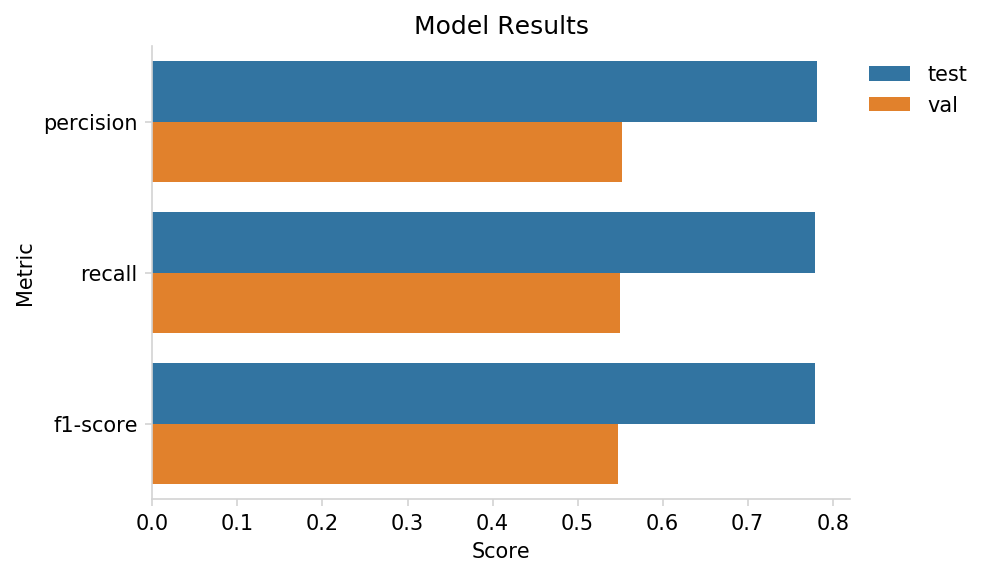

In [75]:
scores = get_average_scores(gdata, cdata)

viz = pd.DataFrame({
    'Score Set' : [k for k, s in scores.items() for _,_ in s.items()],
    'Metric' : [m for _, s in scores.items() for m,_ in s.items()],
    'Score' : [v for _, s in scores.items() for _,v in s.items()]
})

ax = sns.barplot(data=viz, x='Score', y='Metric', hue='Score Set')
ax.set_title('Model Results')
clean_plot()

In [35]:
# load JS visualization code to notebook
shap.initjs()

In [109]:
y = train.copy()['class']
x = train.copy().drop('class', axis = 1)

model = XGBClassifier(n_estimators=80)
model.fit(x, y)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[1], shap_values[1], x)

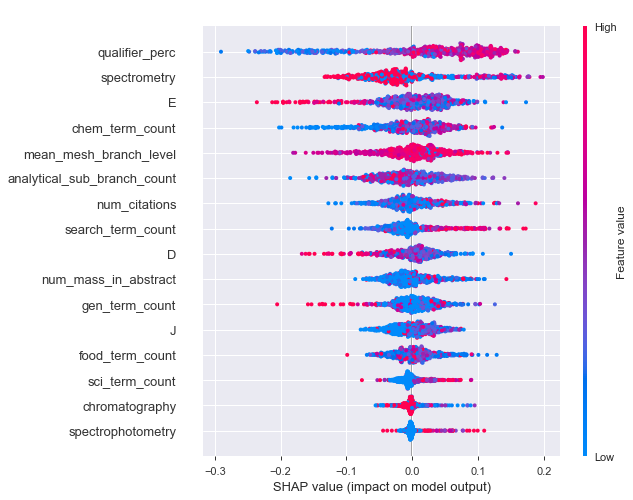

In [111]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], x)